In [1]:
import argparse, os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import cucim
import data.utils_metrics as utils_met
import cucim.skimage.metrics as met

import utils
import data.HCP_dataset_h5_arb as HCP_dataset

number of common Subjects  171


7T scan resolution : 173, 207, 173

3T scan resolution : 145, 174, 174

In [2]:
parser = argparse.ArgumentParser(description="DTI_ARB")
parser.add_argument("--block_size", type=tuple, default=(16,16,16),
                    help="Block Size")
parser.add_argument("--test_size", type=tuple, default=(64,64,16),
                    help="test_size")
parser.add_argument("--crop_depth", type=int, default=15,
                    help="crop across z-axis")
parser.add_argument("--dir", type=str,
                    help="dataset_directory")
parser.add_argument("--batch_size", type=int,
                    help="dataset_directory")
parser.add_argument("--sort", type=bool,
                    help="dataset_directory")
parser.add_argument("--debug", type=bool,
                    help="dataset_directory")
parser.add_argument("--preload", type=bool,
                    help="dataset_directory")
parser.add_argument("--scale", type=tuple, default=(1,1,1),
                    help="test_size")
parser.add_argument("--ret_points", type=bool, default=False,
                    help="test_size")
args = list(parser.parse_known_args())[0]
args.preload = True
args.ret_points = True
args.debug = True
args.dir = "/storage"
args.batch_size = 4
args.sort = True
args.typ = 'upsampled'
args.scale = (1,1,1)
print(args)

Namespace(block_size=(16, 16, 16), test_size=(64, 64, 16), crop_depth=15, dir='/storage', batch_size=4, sort=True, debug=True, preload=True, scale=(1, 1, 1), ret_points=True, typ='upsampled')


In [3]:
ids = utils.get_ids()
ids.sort()
ids = ids[:5]
dataset_hcp = HCP_dataset
dataset_hcp.load_data(args.dir,ids)
training_dataset = dataset_hcp.hcp_data(args,ids)
# testing_dataset = dataset_hcp.hcp_data_test(args,ids)

100610 loaded
102311 loaded
102816 loaded
104416 loaded
105923 loaded


In [28]:
x = training_dataset[0]
print(x[0].shape,x[1].shape,x[2].shape,x[3].shape,x[4].shape,x[5])

(16, 16, 16, 8) (16, 16, 16) (16, 16, 16) (16, 16, 16, 3)


In [29]:
len(training_dataset)

828

In [30]:
def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))

In [31]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=8, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
# testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize)

In [32]:
len(training_data_loader)

103

In [33]:
temp = next(iter(training_data_loader))

In [34]:
temp[0].shape

torch.Size([8, 16, 16, 16, 8])

In [35]:
temp[1].shape

torch.Size([8, 16, 16, 16, 5])

In [36]:
# l=10
# samples = [random.randint(0,len(temp[0])-1) for i in range(l)]

ValueError: only one element tensors can be converted to Python scalars

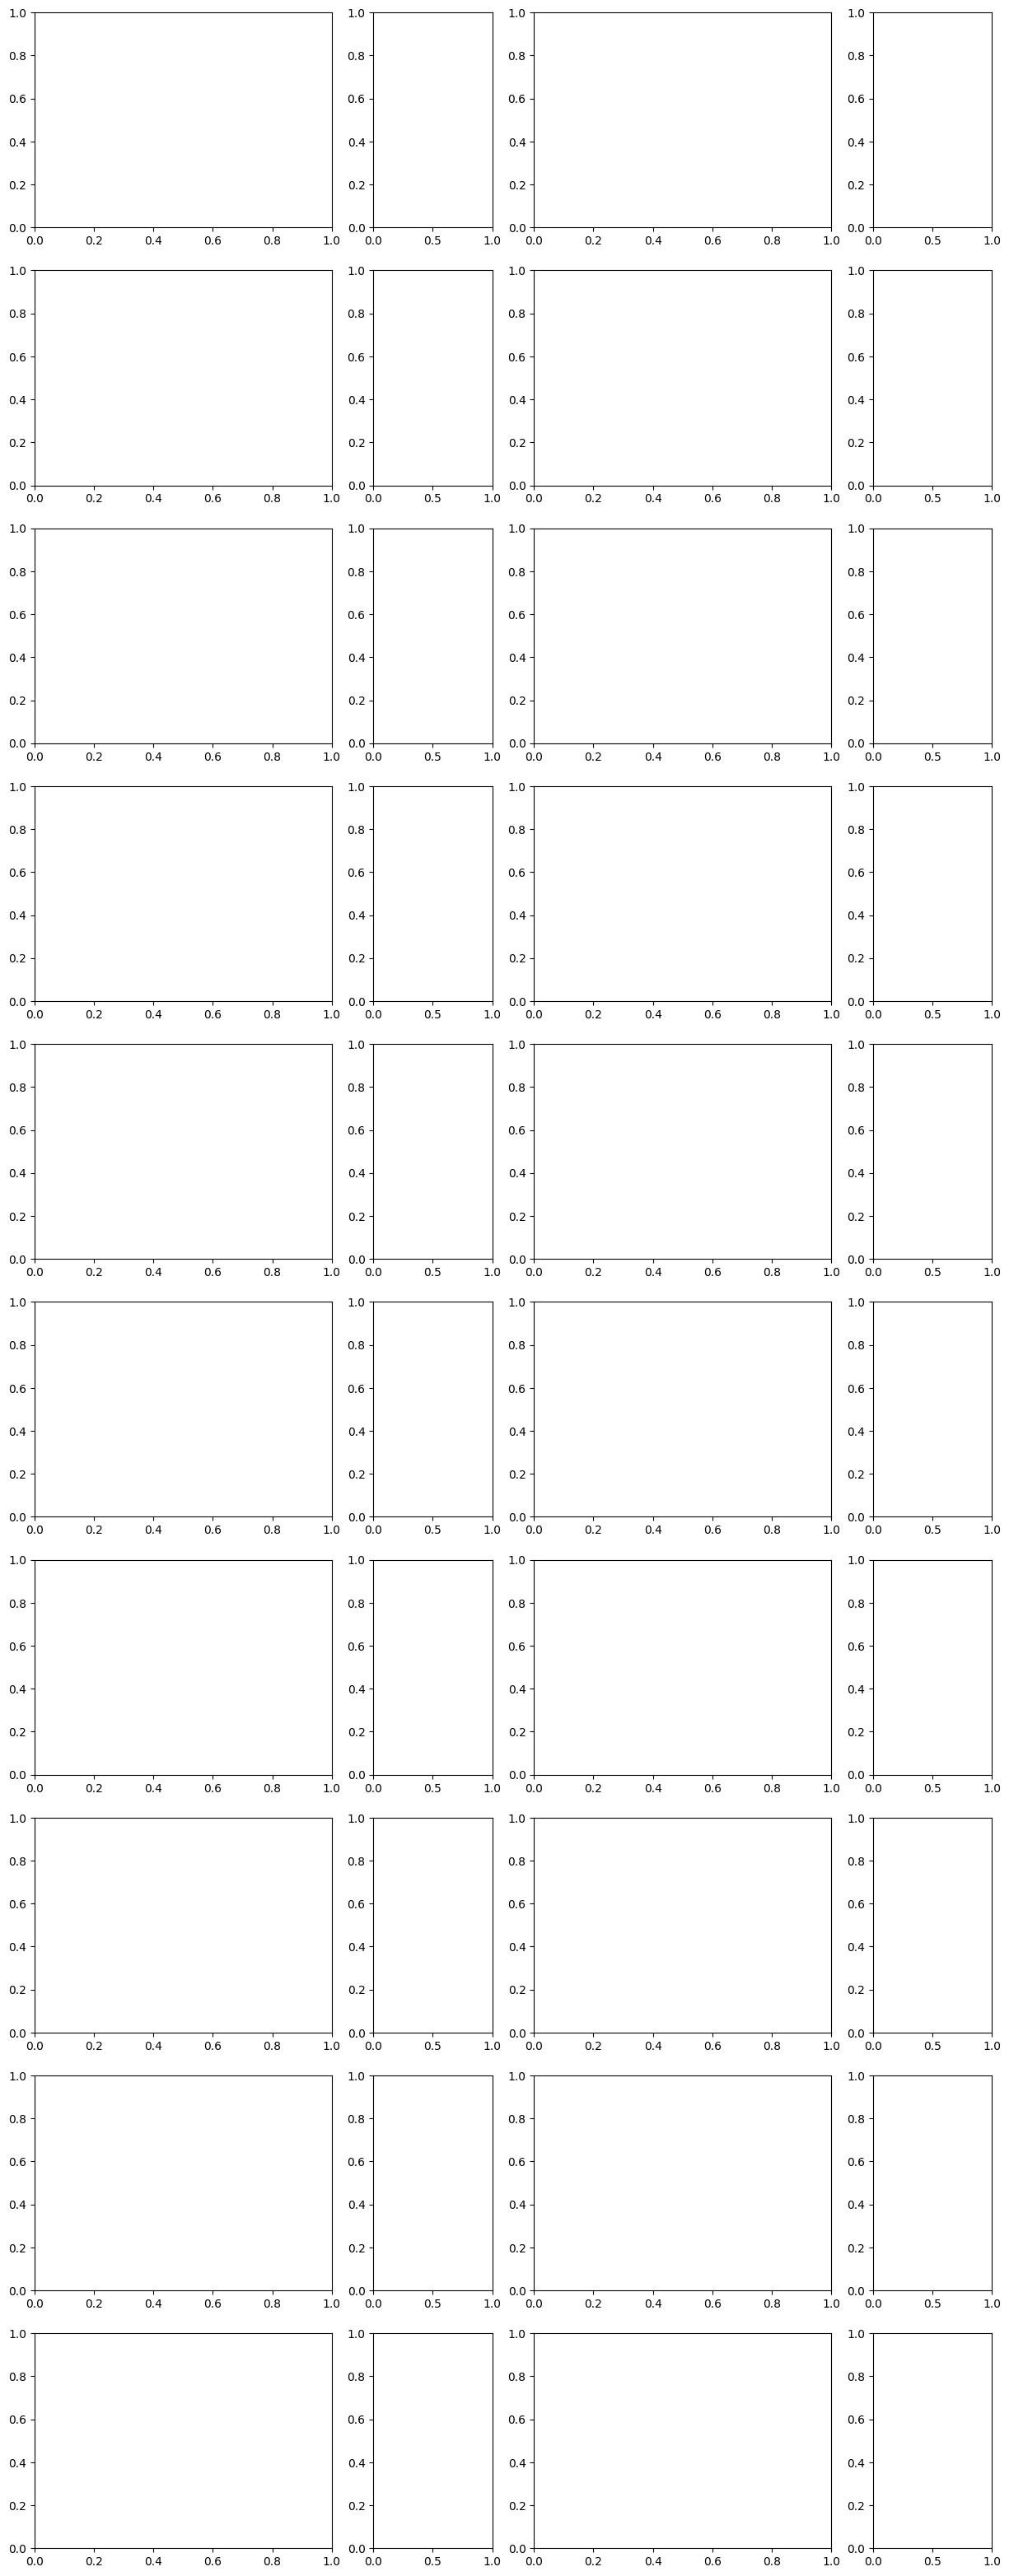

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

fig, ax = plt.subplots(l,4,gridspec_kw={'width_ratios': [2.5, 1,1,1]})

# to change size of subplot's set height of each subplot as 8
fig.set_figheight(4*l)
 
# set width of each subplot as 8
fig.set_figwidth(15)
for i in range(l):
    z = samples[i]
    img = temp[0][z]
    sliceee = temp[0][z][-1]
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][0].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][0].imshow(data_3t[:,:,sliceee,0])
    ax[i][1].imshow(extracted_3t[z][:,:,0,0])
    
    img = temp[1][z]
    sliceee = temp[1][z][-1]
    y,x,w,d = img[0],img[2],int(img[1]-img[0]),int(img[3]-img[2])
    ax[i][2].add_patch(Rectangle((x, y), w, d, fill=False, edgecolor='red', linewidth=1))
    ax[i][2].imshow(data_7t[:,:,sliceee,0])
    ax[i][3].imshow(extracted_7t[z][:,:,0,0])
plt.show()

In [13]:
def resize(data):
    x,y = [],[]
    for i in range(len(data)):
        x.append(data[i][0])
        y.append(np.concatenate([np.expand_dims(data[i][1],axis = 3),np.expand_dims(data[i][2],axis = 3),data[i][3]], axis=3))
    return torch.from_numpy(np.stack(x)),torch.from_numpy(np.stack(y))

In [16]:
training_data_loader = DataLoader(dataset=training_dataset, batch_size=4, shuffle=True, pin_memory=True, drop_last=True,collate_fn=resize)
# testing_data_loader = DataLoader(dataset=testing_dataset, batch_size=1,pin_memory=True,collate_fn=resize)

In [17]:
print(len(training_data_loader))

17


In [18]:
len(training_dataset)

71

In [19]:
temp = next(iter(training_data_loader))

In [20]:
temp[0].shape

torch.Size([4, 32, 32, 32, 8])

In [21]:
temp[1].shape

torch.Size([4, 64, 64, 64, 5])

In [22]:
temp[0].device

device(type='cpu')

In [23]:
t = temp[0].cuda()
print(t.device)

cuda:0


## DUAL ARBNET

In [24]:
from model import rdn
import argparse, os
import numpy as np
import matplotlib.pyplot as plt
import torch
from model import dmri_arb

In [25]:
model = dmri_arb.DMRI_SR()

In [26]:
model

DMRI_SR(
  (encoder): RDN(
    (SFENet1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (SFENet2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (RDBs): ModuleList(
      (0-2): 3 x RDB(
        (convs): Sequential(
          (0): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (1): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(48, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (2): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(80, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
              (1): ReLU()
            )
          )
          (3): RDB_Conv(
            (conv): Sequential(
              (0): Conv3d(112, 32, kernel_size=(3, 3,

In [28]:
optimizer = optim.Adam(model.parameters(), lr=0.02)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800)
# scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer,base_lr = lr, max_lr=0.08, step_size_up  = len(training_data_loader) * 4 , mode  = 'exp_range',cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor = 0.7,patience=5,min_lr = 0.0005)

In [32]:
scheduler.step()

In [43]:
optimizer.defaults['lr']

0.02

In [50]:
sect = [i+20 for i in range(0,90,10)]

In [51]:
sect

[20, 30, 40, 50, 60, 70, 80, 90, 100]

In [36]:
dir(optimizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cuda_graph_capture_health_check',
 '_group_tensors_by_device_and_dtype',
 '_init_group',
 '_optimizer_step_code',
 '_optimizer_step_post_hooks',
 '_optimizer_step_pre_hooks',
 '_patch_step_function',
 '_process_value_according_to_param_policy',
 '_warned_capturable_if_run_uncaptured',
 '_zero_grad_profile_name',
 'add_param_group',
 'defaults',
 'load_state_dict',
 'param_groups',
 'profile_hook_step',
 'register_step_post_hook',
 'register_step_pre_hook',
 'state',
 'state_dict',
 'step',
 'zero_grad']

In [25]:
temp = next(iter(training_data_loader))
print(temp[0].shape)
inp = torch.permute(temp[0], (0,4,1,2,3))
print(inp.shape)

torch.Size([4, 32, 32, 32, 8])
torch.Size([4, 8, 32, 32, 32])


In [26]:
inp = inp.to("cuda")

In [27]:
model = model.to("cuda")

In [28]:
model.set_scale(scale = (1.2,1.2,1.2))

In [29]:
out = model(inp)

In [30]:
out.shape

torch.Size([4, 5, 38, 38, 38])

In [31]:
out = torch.permute(out, (0,2,3,4,1))
print(out.shape)

torch.Size([4, 38, 38, 38, 5])


In [32]:
temp[1].shape

torch.Size([4, 64, 64, 64, 5])

In [33]:
for iteration, (lr_tensor, hr_tensor) in enumerate(testing_data_loader, 1):
    print(lr_tensor.shape,hr_tensor.shape)

torch.Size([1, 145, 174, 145, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 145, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])
torch.Size([1, 145, 174, 143, 8]) torch.Size([1, 173, 207, 173, 5])


In [34]:
import numpy as np

In [35]:

sect = [10,25,35,45,50]
scale = {i:np.random.uniform(1,2,3) for i in sect}
scale[0] = (1,1,1)

In [36]:
scale

{10: array([1.81138511, 1.58001414, 1.47434443]),
 25: array([1.01124638, 1.22630205, 1.66937451]),
 35: array([1.78339203, 1.87363618, 1.8684519 ]),
 45: array([1.51703386, 1.24300496, 1.17588612]),
 50: array([1.62551997, 1.87603926, 1.70837848]),
 0: (1, 1, 1)}

In [37]:
lr_tensor.shape

torch.Size([1, 145, 174, 143, 8])

In [ ]:
lr_tensor = lr_tensor[:,3:70,:]

In [37]:
model.set_scale(scale = (1.2,1.2,1.2))

In [39]:
inp = torch.permute(lr_tensor, (0,4,1,2,3))

In [41]:
dev = torch.device("cuda")

In [42]:
inp = inp.to(dev)

In [43]:
out = model(inp)

RuntimeError: GET was unable to find an engine to execute this computation